## Topic Modeling and LDA

Topic Modeling, a method for discovery of representative groups of words from a set of documents, which implicitly present topics. 

In addition, the technique we use is LDA, which is one of the most common topic modeling approaches. The basic idea of LDA is to regard every document as a mixture of topics and to assign every word in a document to one of the document's topics.

However, LDA trains the topic models in an unsupervised way. This has both good and bad aspects. The good part is, we don't have to label the topics of each documents. But in contrast, we can't expect the LDA output to be understandable to human being.   

So, in order to guarantee the quality of a LDA model, we introduce an evaluation approach called coherence value. 

Let us shortly explain how coherence value works. Coherence value approach makes an assumption that if words always appear together, then they are likely to belong to the same topic. And, a topic model with higher coherence value implies a better interpretability to human. 

In the following, with the help of **Gensim** we find documents' topics using LDA and further evaluate the LDA models by computing coherence value.

<font color="blue"/>

### dsp:
  * &#x1f642; Nice to find an introductory text here at the top of the Notebook.
  * To consider a topic a "representative group of words" is not exact. In the context of LDA the topic is represented by a probability distribution over all words. Picking the most probable words as a desription of the topic is only an approximation.

### Gensim functions we use
1. LdaModel(corpus, id2word, num_topics): train a LDA model
    - params:
        - corpus: gensim corpus
        - id2word: mapping from word IDs to words. [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) type, defined by gensim library
        - num_topics: user-defined number of topics
    - return:
        - gensim LDA model
2. CoherenceModel(model, corpus, coherence): build a model for topic coherence
    - params:
        - model: gensim LDA model
        - corpus: gensim corpus
        - coherence: way of coherence measure, "u_mass" or "c_v"
    - return:
        - gensim coherence model
3. get_coherence(): a method of gensim coherence model class
    - return: coherence value of the gensim coherence model

<font color="blue"/>

### dsp:
  * It might be useful to desribe the structure of the gensim LDA model.
  * "u_mass" and "c_v" are never explained in this Notebook
 

In [1]:
from gensim import corpora, models, similarities
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

import os
import shutil
import pickle
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from matplotlib import colors

pyLDAvis.enable_notebook()

<font color="blue"/>

### dsp:
  * This import list might benefit from some sorting and some empty lines to give it some structure.

#### 0. Create data set with all bank quarterly reports
- params:
    - source_folder: path to the corpus folder (e.g. "../spacy_corpus/") 
    - target_folder: path to the target folder (e.g. "../bank_quarterly_report/")
    - non_german_file_path: path to the "non_german_files.txt"

In [2]:
def pick_bank_quarterly_report(source_folder, target_folder, non_german_file_path):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    non_german_files = []
    with open(non_german_file_path, 'r') as fr:
        for line in fr:
            non_german_files.append(line.strip())    

    texts = []
    filenames = []

    for root, dirs, files in os.walk(source_folder):
        for f in files:
            if f[:-11] not in non_german_files and ("Bank" in f or "bank" in f) and ("Quarterly" in f or "quarterly" in f):
                try:
                    src_file = root + '/' + f
                    shutil.copy(src_file, target_folder)
                except:
                    print('Error while creating data set for LDA: ', f)

In [3]:
target_folder = '../bank_quarterly_report/'
source_folder = '../spacy_corpus/'
non_german_file_path = './non_german_files.txt'

pick_bank_quarterly_report(source_folder, target_folder, non_german_file_path)

<font color="blue"/>

### dsp:
  * (I haven't had the energy to verify the folder structure here. I had some problems with relative paths because Python seemed to resolve the symbolic link.)



<font color="blue"/>

### dsp:
  * &#x1f642; Defining a function in one cell and then calling it in the next cell is a pattern that I have now seen quite a few times. It has the benefits, that you have a function definition that you can call a few times with different parameters, and you are able to see some results in the second cell. That is a pattern worth repeating.

#### 1. Initialize LDA -- compute prerequisite data for LDA 
- params:
    - folder_path: cleand preprocessed data folder
    - non_german_file_path: a list of all English files
- return variables:
    - texts: list of input text
    - dct: [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) type, defined by gensim library
    - corpus: doc2bow, tokenized and nomalized list

In [4]:
def LDA_initialize(folder_path):
    texts = []
    filenames = []

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            try:
                with open(root+'/'+f, 'rb') as fr:
                    filenames.append(f)
                    document_tokens = pickle.load(fr)
                    texts.append(document_tokens)
            except:
                print('Error while processing: ', f)
    
    dct = Dictionary(texts)
    corpus = [dct.doc2bow(doc) for doc in texts]
    
    return texts, dct, corpus

#### Note:
**In this notebook, the data set we use is the collection of all bank quartly reports.** 

**bank_quartely_report** should be located under Text_Mining_Lab folder! If not, try to use the absolute path to the folder

In [5]:
%%time
warnings.filterwarnings("ignore")
#please modify the path
# non_german_file_path = '/home/bit/chao/LabShare/data/non_german_files.txt'
# bank_quarterly_report_path = '/home/bit/chao/LabShare/data/chui_ma/bank_quarterly_report/'
bank_quarterly_report_path = '../bank_quarterly_report/'
texts, dct, corpus = LDA_initialize(bank_quarterly_report_path)

CPU times: user 163 ms, sys: 6.94 ms, total: 170 ms
Wall time: 169 ms


#### 2. LDA Topic Modeling and Model Evaluation
In this stage, we try multiple topic models with different numbers of topics and compute the coherence values of them.
> step 2.1 get_model_list(): 
>> get a list of LDA models with different numbers of topics from multiple calls of Gensim function **LdaModel()**

> step 2.2 compute_coherence_values(): 
>> get a list of CV and UMass coherence values of each topic model by calling Gensim function **CoherenceModel()** per model.

#### step 2.1: get_model_list(dictionary, corpus, limit, start=2, step=3)
- params:
    - dictionary: gensim dictionary
    - corpus: gensim corpus
    - start, limit, step: test topic numbers from **start** to **limit** with a step size **step**
- return variables:
    - model_list: a list of LDA models

In [6]:
def get_model_list(dictionary, corpus, limit, start=2, step=3):
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)

    return model_list

#### step 2.2: compute_coherence_values(model_list, dictionary, corpus, texts)

- params:
    - model_list : List of LDA topic models
    - dictionary : gensim dictionary
    - corpus : gensim corpus
    - texts : list of input texts

- variables:
    - CV_coherence_values : a list of CV coherence values of LDA models
    - UM_coherence_values : a list of UMass coherence values of LDA models

In [7]:
def compute_coherence_values(model_list, dictionary, corpus, texts):
    CV_coherence_values = []
    UM_coherence_values = []
    for model in model_list:
        CVcoherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        CV_coherence_values.append(CVcoherencemodel.get_coherence())
        
        UMcoherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        UM_coherence_values.append(UMcoherencemodel.get_coherence())        

    return CV_coherence_values, UM_coherence_values

### main function of experiment

In [8]:
%%time
start = 5
limit = 20
step = 1

model_list = get_model_list(dictionary=dct, corpus=corpus, start=start, limit=limit, step=step)
CV_coherence_values, UMass_coherence_values = compute_coherence_values(model_list, dictionary=dct, corpus=corpus, texts=texts)

CPU times: user 17.9 s, sys: 904 ms, total: 18.9 s
Wall time: 30.2 s


### visualize the evalution process
- params:
    - start, limit, step: test topic numbers from **start** to **limit** with a step size **step**
    - CV_coherence_values, UMass_coherence_values: output from **compute_coherence_values** function

In [9]:
def visualize_coherence_scores(start, limit, step, UMass_coherence_values, CV_coherence_values):
    # Show UMass scores
    plt.figure()
    x = range(start, limit, step)
    plt.plot(x, UMass_coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("UMass Coherence score")
    plt.legend(("UMass_coherence_values"), loc='best')
    plt.show()

    # Show CV scores
    plt.figure()
    plt.plot(x, CV_coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("CV Coherence score")
    plt.legend(("CV_coherence_values"), loc='best')
    plt.show()

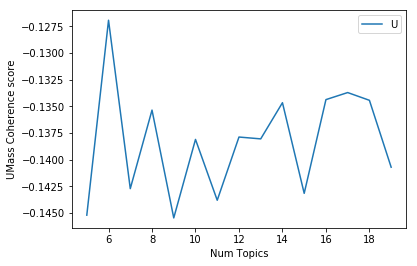

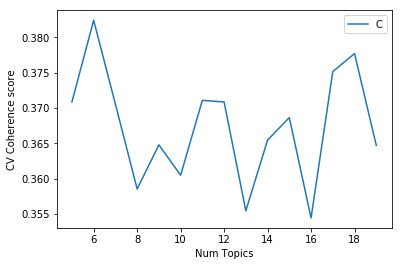

In [10]:
visualize_coherence_scores(start, limit, step, UMass_coherence_values, CV_coherence_values)

### decide the number of topics and visualize the best LDA model
- selection scheme: test those numbers of topics with rather higher coherence scores

In [11]:
best_UMass_model = model_list[np.argmax(UMass_coherence_values) ]
pyLDAvis.gensim.prepare(best_UMass_model, corpus, dct)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.001377  0.002333       1        1  46.981777
1      0.004434  0.001987       2        1  29.506811
0      0.004005  0.000543       3        1  18.214340
4     -0.006218  0.000293       4        1   2.974353
5     -0.003023 -0.001017       5        1   1.887171
3      0.002180 -0.004139       6        1   0.435546, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
413   Default  373.000000            bank  373.000000  30.0000  30.0000
2779  Default  348.000000         quartal  348.000000  29.0000  29.0000
2216  Default  269.000000          liegen  269.000000  28.0000  28.0000
1113  Default  287.000000        ergebnis  287.000000  27.0000  27.0000
1719  Default  261.000000            höhe  261.000000  26.0000  26.0000
858   Default  335.000000         deutsch  335.000000  25.0000  25.0000
286   Default  232.000000        aufgrund  232.000000  24.0000  24.0000
3968  Default  305.000000      wesentlich  305.000000  23.0000  23.0000
4673  Default  252.000000     commerzbank  252.000000  22.0000  22.0000
1691  Default  255.000000            hoch  255.000000  21.0000  21.0000
1173  Default  228.000000         erträge  228.000000  20.0000  20.0000
3237  Default  206.000000         sonstig  206.000000  19.0000  19.0000
2028  Default  185.000000         konzern  185.000000  18.0000  18.0000
3636  Default  159.000000       vergleich  159.000000  17.0000  17.0000
3922  Default  147.000000       weiterhin  147.000000  16.0000  16.0000
610   Default  160.000000        betragen  160.000000  15.0000  15.0000
3836  Default  186.000000         vorjahr  186.000000  14.0000  14.0000
5558  Default  228.000000         segment  228.000000  13.0000  13.0000
3175  Default  141.000000       september  141.000000  12.0000  12.0000
3319  Default  190.000000         steuern  190.000000  11.0000  11.0000
1736  Default  199.000000            ifrs  199.000000  10.0000  10.0000
857   Default  150.000000        deutlich  150.000000   9.0000   9.0000
500   Default  123.000000      beinhalten  123.000000   8.0000   8.0000
2136  Default  171.000000          kunden  171.000000   7.0000   7.0000
1615  Default  168.000000        halbjahr  168.000000   6.0000   6.0000
517   Default  159.000000        belaufen  159.000000   5.0000   5.0000
1877  Default  188.000000            juni  188.000000   4.0000   4.0000
2987  Default  198.000000  risikovorsorge  198.000000   3.0000   3.0000
2704  Default  172.000000         positiv  172.000000   2.0000   2.0000
3546  Default  141.000000     unternehmen  141.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
2217   Topic6    0.328597         liegend   55.432316   0.3082  -6.8488
1334   Topic6    0.183169      fortsetzen   28.984613   0.3722  -7.4332
2790   Topic6    0.729652          rahmen  135.820816   0.2098  -6.0510
286    Topic6    1.169377        aufgrund  232.686798   0.1431  -5.5794
413    Topic6    1.762481            bank  373.240601   0.0808  -5.1691
2028   Topic6    0.935871         konzern  185.606384   0.1464  -5.8021
937    Topic6    0.506015          dürfen   92.718239   0.2256  -6.4170
1719   Topic6    1.241880            höhe  261.408020   0.0869  -5.5192
4050   Topic6    0.584221        zeitwert  109.456001   0.2033  -6.2733
593    Topic6    0.639513       bestimmen  123.482323   0.1732  -6.1829
610    Topic6    0.768972        betragen  160.580643   0.0948  -5.9985
2779   Topic6    1.396920         quartal  348.756439  -0.0838  -5.4016
3569   Topic6    0.424898     unverändert   76.899902   0.2379  -6.5917
2216   Topic6    1.089909          liegen  269.339569  -0.0736  -5.6497
1066   Topic6    0.645988       enthalten  134.385910   0.0986  -6.1728
3319   Topic6    0.817797         steuern  190.829758  -0.0162  -5.93

After implementation of LDA model, we would like to continue an interesting experiment about [Hierarchical LDA](08-Hierarchical_LDA.ipynb)